 Fase de ETL 

In [115]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from datetime import datetime


In [116]:
# Carga de datasets 
df_pacientes = pd.read_csv("pacientes_salud_mental.csv")
df_diagnosticos = pd.read_csv("diagnosticos.csv")
df_internaciones = pd.read_csv("internaciones.csv")


En primer lugar, se procedió a la importación de las librerías esenciales para el procesamiento y análisis de datos: pandas para la manipulación de estructuras tabulares, numpy para operaciones numéricas, y datetime para el tratamiento de variables temporales. A continuación, se efectuó la carga de las tres fuentes principales de información: la base de pacientes del sistema de salud mental, los diagnósticos registrados y las internaciones realizadas. Esta segmentación responde a una lógica de organización estructurada que permite, en etapas posteriores, la vinculación entre registros y la generación de nuevas variables derivadas, conforme a los objetivos del análisis.

In [117]:
# Ver columnas disponibles en cada dataset
print("Columnas de PACIENTES:")
print(df_pacientes.columns)

print("\nColumnas de DIAGNÓSTICOS:")
print(df_diagnosticos.columns)

print("\nColumnas de INTERNACIONES:")
print(df_internaciones.columns)


Columnas de PACIENTES:
Index(['paciente_nro', 'paciente_fecha_nacimiento', 'paciente_sexo',
       'paciente_lat', 'paciente_long', 'paciente_barrio',
       'paciente_area_referencia', 'origen_dato', 'paciente_localidad',
       'paciente_provincia'],
      dtype='object')

Columnas de DIAGNÓSTICOS:
Index(['nro_paciente', 'fecha_carga_diagnostico', 'codigo_cie_10',
       'descripcion_cie_10', 'diagnostico_manual', 'codigo_subjetivo',
       'descripcion_subjetivo', 'diagnostico_manual_subjetivo', 'subjetivo',
       'objetivo', 'problema', 'plan', 'obra_social', 'centro_atencion',
       'nombre_localidad', 'especialidad', 'servicio', 'paciente_edad_actual',
       'diagnostico_edad'],
      dtype='object')

Columnas de INTERNACIONES:
Index(['paciente_nro', 'nombre_centro', 'nombre_localidad', 'servicio',
       'fecha_ingreso', 'fecha_egreso', 'dias_total_estada',
       'especialidad_solicitante', 'fecha_ingreso_servicio',
       'fecha_egreso_al_servicio', 'dias_estada', 'especial

A fin de contextualizar el contenido informacional de cada una de las bases disponibles, se realizó una visualización preliminar de las columnas que integran los datasets de pacientes, diagnósticos e internaciones. Este procedimiento permitió detectar, en primer término, la existencia de variables redundantes, posibles claves de unión y datos relevantes para la construcción del modelo. 

In [118]:
# Realizamos el merge con la tabla intermedia de pacientes
df_merged_int = df_internaciones.merge(df_pacientes, on='paciente_nro', how='left')

# Mostramos estructura para verificar
df_merged_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40253 entries, 0 to 40252
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   paciente_nro                         40253 non-null  int64  
 1   nombre_centro                        40253 non-null  object 
 2   nombre_localidad                     40253 non-null  object 
 3   servicio                             40253 non-null  object 
 4   fecha_ingreso                        40253 non-null  object 
 5   fecha_egreso                         40253 non-null  object 
 6   dias_total_estada                    40253 non-null  int64  
 7   especialidad_solicitante             40253 non-null  object 
 8   fecha_ingreso_servicio               40253 non-null  object 
 9   fecha_egreso_al_servicio             40253 non-null  object 
 10  dias_estada                          40253 non-null  int64  
 11  especialidad_actual         

Para incorporar al análisis variables contextuales vinculadas a episodios de internación, se procedió a la unión entre la tabla de internaciones y la estructura intermedia de pacientes, utilizando como clave el identificador único paciente_nro. Esta operación permitirá incorporar información relacionada con motivos de internación, días totales de estadía, especialidades intervinientes y situación laboral, las cuales pueden funcionar como factores explicativos o moderadores del riesgo suicida.

In [119]:
# Agrupamos internaciones por paciente
df_internaciones_agg = df_internaciones.groupby('paciente_nro').agg({
    'dias_total_estada': 'mean',
    'tipo_egreso': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Desconocido',
    'especialidad_actual': lambda x: any('MENTAL' in str(i).upper() for i in x)
}).reset_index()

# Renombramos columnas para mayor claridad
df_internaciones_agg.rename(columns={
    'dias_total_estada': 'dias_estada_avg',
    'tipo_egreso': 'tipo_egreso_mas_frecuente',
    'especialidad_actual': 'internacion_salud_mental'
}, inplace=True)

# Agregamos la cantidad de internaciones
conteo = df_internaciones['paciente_nro'].value_counts().rename('n_internaciones').reset_index()
conteo.columns = ['paciente_nro', 'n_internaciones']

# Combinamos con el agregado anterior
df_internaciones_agg = df_internaciones_agg.merge(conteo, on='paciente_nro', how='left')

df_internaciones_agg.head(10)



,paciente_nro,dias_estada_avg,tipo_egreso_mas_frecuente,internacion_salud_mental,n_internaciones
0,1411,1.388060,EGRESO POR ORDEN MEDICA,False,67
1,1960,6.250000,ALTA,False,4
2,4632,2.333333,EGRESO POR ORDEN MEDICA,False,3
3,5316,2.000000,DEFUNCION,False,1
4,6209,5.500000,EGRESO POR DEFUNCION,False,4
5,6316,10.400000,ALTA,False,5
6,6517,1.000000,ALTA,False,2
7,6667,15.000000,ALTA,False,2
8,6796,5.000000,DEFUNCION,False,1
9,6823,14.000000,EGRESO POR ORDEN MEDICA,False,3


Con el propósito de enriquecer el dataset con información derivada de las trayectorias asistenciales, se elaboraron variables agregadas a partir del dataset de internaciones. Estas incluyen: la cantidad total de internaciones por paciente (n_internaciones), el promedio de días de estadía (dias_estada_avg), el tipo de egreso más frecuente (tipo_egreso_mas_frecuente) y una variable indicadora (internacion_salud_mental) que marca si el paciente fue internado alguna vez bajo una especialidad vinculada a salud mental. Estas características permiten identificar perfiles clínicos más complejos o crónicos, relevantes para la predicción del riesgo suicida.

In [120]:
import unicodedata

# Función para normalizar texto: pasa a minúsculas, remueve tildes y caracteres raros
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
        return texto
    return ""

# Lista de palabras clave asociadas a riesgo suicida
palabras_clave = ['suicidio', 'intento', 'ideacion', 'autolesion', 'no quiere vivir']

# Normalizamos el campo 'subjetivo'
df_diagnosticos['subjetivo_normalizado'] = df_diagnosticos['subjetivo'].apply(normalizar_texto)

# Creamos la variable binaria de riesgo suicida SOLO si el código CIE-10 comienza con F
def marcar_riesgo_f(row):
    texto = row['subjetivo_normalizado']
    cie = row['codigo_cie_10']
    if isinstance(texto, str) and isinstance(cie, str) and cie.startswith('F'):
        return int(any(palabra in texto for palabra in palabras_clave))
    return 0

df_diagnosticos['riesgo_suicida'] = df_diagnosticos.apply(marcar_riesgo_f, axis=1)

# Agrupamos por paciente y generamos resumen
df_diag_agg = df_diagnosticos.groupby('nro_paciente').agg({
    'riesgo_suicida': 'max',
    'codigo_cie_10': 'count'
}).rename(columns={
    'codigo_cie_10': 'n_diagnosticos'
}).reset_index()

# Vista previa
print(df_diag_agg.head())

# Totales
print("Total pacientes con riesgo suicida:", df_diag_agg['riesgo_suicida'].sum())


   nro_paciente  riesgo_suicida  n_diagnosticos
0          9599               0               2
1          9767               0               4
2         19231               0               1
3         21992               0               1
4         23219               0              15
Total pacientes con riesgo suicida: 1121


Con el propósito de incorporar al dataset información clínica relevante vinculada a los motivos de consulta, se construyeron variables agregadas a partir del dataset de diagnósticos. En particular, se diseñó una variable indicadora de riesgo suicida (`riesgo_suicida`) que se activa únicamente cuando coexisten dos condiciones: la presencia de expresiones clave en el campo subjetivo (como “suicidio”, “autolesión”, “no quiere vivir”) y la asociación con un código CIE-10 perteneciente al bloque F, correspondiente a trastornos mentales y del comportamiento.

Dado que el campo `subjetivo` se encuentra en lenguaje natural y sin control de formato, fue necesario aplicar una etapa previa de normalización (conversión a minúsculas, remoción de tildes y caracteres especiales). En contraste, el campo `codigo_cie_10` no requiere transformaciones por tratarse de un sistema estandarizado.

Además, se construyó una variable adicional (`n_diagnosticos`) que cuantifica el total de diagnósticos registrados por paciente, lo que puede reflejar continuidad en la atención o mayor complejidad clínica. Ambas variables contribuyen a robustecer la matriz de entrenamiento, aportando información sensible a la detección de poblaciones en riesgo.


In [121]:
import unicodedata

# Función de normalización del texto
def normalizar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')
        return texto
    return ""

# Aplicar normalización al campo subjetivo
df_diagnosticos["subjetivo_normalizado"] = df_diagnosticos["subjetivo"].apply(normalizar_texto)

# Crear columnas binarias por síntoma
df_diagnosticos["refiere_ansiedad"] = df_diagnosticos["subjetivo_normalizado"].str.contains("ansiedad").astype(int)
df_diagnosticos["refiere_estres"] = df_diagnosticos["subjetivo_normalizado"].str.contains("estres").astype(int)
df_diagnosticos["refiere_insomnio"] = df_diagnosticos["subjetivo_normalizado"].str.contains("insomnio").astype(int)

# Agrupar por paciente y consolidar en columnas finales
df_subjetivas_agg = df_diagnosticos.groupby("nro_paciente")[["refiere_ansiedad", "refiere_estres", "refiere_insomnio"]].max().reset_index()

# Vista previa
df_subjetivas_agg.head()


,nro_paciente,refiere_ansiedad,refiere_estres,refiere_insomnio
0,9599,0,0,0
1,9767,0,0,0
2,19231,0,0,0
3,21992,0,0,0
4,23219,0,0,0


Con el propósito de incorporar al dataset información clínica subjetiva vinculada a los motivos de consulta, se elaboraron variables agregadas a partir del campo libre subjetivo contenido en el dataset de diagnósticos. En primer lugar, se aplicó una etapa de normalización del texto —conversión a minúsculas, remoción de tildes y caracteres especiales— con el objetivo de facilitar la detección de palabras clave en lenguaje natural, habitualmente registradas sin control de formato ni estandarización.

A continuación, se identificó la presencia de los términos “ansiedad”, “estrés” e “insomnio” dentro del contenido textual normalizado, sin considerar su posición ni la cantidad de apariciones. Esta operación permitió construir, mediante agrupamiento por número de paciente (nro_paciente), tres variables indicadoras:

refiere_ansiedad: toma valor 1 si el paciente refirió ansiedad en al menos una consulta;

refiere_estres: toma valor 1 si manifestó estrés;

refiere_insomnio: toma valor 1 si mencionó insomnio.

Estas variables permiten capturar manifestaciones clínicas subjetivas que, si bien no siempre constituyen un diagnóstico formal, pueden representar signos tempranos o persistentes de sufrimiento emocional, contribuyendo a enriquecer la matriz de entrenamiento con información sensible al análisis del riesgo suicida.



In [122]:
# Ver primeros valores únicos tal como están
df_diagnosticos["obra_social"].value_counts(dropna=False).head(20)


obra_social
PROGRAMA SUMAR                                                                238443
OSEF - OSPTF -  OBRA SOCIAL DE LA PROV DE TIERRA DEL FUEGO                     72718
OSPTF - OBRA SOCIAL DE LA PROVINCIA DE TIERRA DEL FUEGO                        60732
PARTICULARES ARGENTINOS                                                        16157
SIN IDENTIFICAR                                                                16020
SIN COBERTURA                                                                  11354
OSUTHGRA- O.S. UNION TRAB. HOTELEROS Y GASTRONOMICOS DE LA REP. ARG.            8787
O.S.E.C.A.C-OBRA SOCIAL DE LOS EMPLEADOS DE COMERCIO Y ACTIVIDADES CIVILES      8639
UOM -OSUOMRA- OBRA SOCIAL DE LA UNION OBRERA METALUR. DE LA R.A.                8069
OSECAC - OBRA SOCIAL DE EMPLEADOS DE COMERCIO Y ACTIVIDADES CIVILES             7614
UNION PERSONAL- O.S. DE LA UNION DEL PERSONAL CIVIL DE LA NACION                7422
SANCOR SALUD - ASOCIACIÓN MUTUAL SANCOR SALUD        

In [123]:
import unicodedata

# Función de normalización
def normalizar_texto(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto).encode("ascii", "ignore").decode("utf-8")
    return texto

# Clasificación robusta de cobertura desde obra_social
def clasificar_cobertura(valor):
    texto = normalizar_texto(valor)

    if any(x in texto for x in ["sumar", "sin identificar", "sin cobertura", "particulares argentinos"]):
        return "SIN COBERTURA"
    elif any(x in texto for x in ["osef", "osptf", "ministerio de salud", "iosfa", "inssjp", "profe", "inst. nac. servicios sociales jubilados"]):
        return "OBRA SOCIAL ESTATAL"
    elif texto != "":
        return "OBRA SOCIAL PAGA"
    else:
        return "SIN DATOS"

# Aplicar clasificación
df_diagnosticos["cobertura_cat"] = df_diagnosticos["obra_social"].apply(clasificar_cobertura)

# Vista de distribución
print(df_diagnosticos["cobertura_cat"].value_counts(dropna=False))


cobertura_cat
SIN COBERTURA          281974
OBRA SOCIAL ESTATAL    146128
OBRA SOCIAL PAGA       101907
SIN DATOS                 257
Name: count, dtype: int64


Con el propósito de incorporar al análisis una variable que refleje el acceso a cobertura sanitaria, se procedió a clasificar las obras sociales registradas en los diagnósticos bajo tres categorías principales. Esta clasificación se realizó a partir del campo obra_social, el cual contiene denominaciones heterogéneas y no estandarizadas.

Para facilitar su análisis, se creó la variable cobertura_cat, definida de la siguiente manera:

-SIN COBERTURA: incluye expresiones tales como “programa sumar”, “sin identificar”, “sin cobertura” y “particulares argentinos”, que refieren a situaciones de atención sin intermediación de un financiador formal;

-OBRA SOCIAL ESTATAL: comprende a organismos públicos como OSEF, OSPTF, PROFE, IOSFA, INSSJP y otros sistemas de salud dependientes del Estado;

-OBRA SOCIAL PAGA: abarca al resto de las entidades, usualmente prestadoras privadas, mutuales o prepagas;

-SIN DATOS: se asigna en casos residuales donde la información no se encuentra disponible o legible.

Esta clasificación permite distinguir entre distintos niveles de acceso al sistema de salud y su posible relación con la detección, frecuencia o gravedad de los cuadros atendidos. La incorporación de esta variable busca captar desigualdades estructurales que podrían incidir en la aparición o persistencia de situaciones de riesgo.



In [124]:
# Centro de atención más frecuente por paciente
df_centro = df_diagnosticos.groupby("nro_paciente")["centro_atencion"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
).reset_index()

df_centro = df_centro.rename(columns={"centro_atencion": "centro_atencion_mas_frecuente"})

print(df_centro)


       nro_paciente        centro_atencion_mas_frecuente
0              9599                                 HRRG
1              9767         HOSPITAL REGIONAL DE USHUAIA
2             19231         HOSPITAL REGIONAL DE USHUAIA
3             21992         HOSPITAL REGIONAL DE USHUAIA
4             23219         HOSPITAL REGIONAL DE USHUAIA
...             ...                                  ...
11037        325373                                 HRRG
11038        325482  CENTRO PROVINCIAL DE REHABILITACIÓN
11039        325552                                C.A.T
11040        325639                               CAPS 7
11041        325721                                C.A.T

[11042 rows x 2 columns]


Con el propósito de incorporar una variable contextual asociada a la trayectoria asistencial de cada paciente, se construyó una nueva columna que identifica el centro de atención más frecuentemente registrado en sus diagnósticos. Para ello, se aplicó una función de agregación sobre el campo centro_atencion, agrupando por nro_paciente y seleccionando la moda (valor más repetido). Esta información puede aportar indicios sobre la continuidad asistencial, el nivel de especialización del servicio o incluso la territorialidad del seguimiento clínico.

In [125]:
# Asegurar formato datetime
df_internaciones["fecha_ingreso"] = pd.to_datetime(df_internaciones["fecha_ingreso"], errors='coerce')

# Ordenar por fecha y paciente
df_orden_nivel = df_internaciones.sort_values(by=["paciente_nro", "fecha_ingreso"], ascending=[True, False])

# Obtener el último nivel de estudio registrado por paciente
df_nivel_estudio = df_orden_nivel.groupby("paciente_nro").first().reset_index()
df_nivel_estudio = df_nivel_estudio[["paciente_nro", "nivel_estudio"]]

print(df_nivel_estudio)

       paciente_nro         nivel_estudio
0              1411  PRIMARIO            
1              1960  PRIMARIO INCOMPLETO 
2              4632  SECUNDARIO          
3              5316  SIN ESPECIFICAR     
4              6209  SIN ESPECIFICAR     
...             ...                   ...
11932        325349  UNIVERSITARIO       
11933        325373  SECUNDARIO          
11934        325516  SIN ESPECIFICAR     
11935        325552  NUNCA ASISTIÓ       
11936        325732                  None

[11937 rows x 2 columns]


Con el propósito de incorporar al análisis información vinculada al contexto educativo de los pacientes, se construyó una variable categórica denominada nivel_estudio, obtenida a partir del último registro disponible en la base de internaciones. Para ello, se ordenaron cronológicamente los episodios por paciente y se extrajo el valor correspondiente a la fecha más reciente de ingreso. Esta estrategia permite capturar la situación educativa declarada más actual, la cual puede constituir un indicador relevante para el análisis del riesgo suicida, especialmente en población joven. La variable resultante incluye categorías como “PRIMARIO”, “SECUNDARIO”, “UNIVERSITARIO”, “NUNCA ASISTIÓ” y casos sin información específica.

Con el objetivo de incorporar una dimensión socioeconómica al análisis, se construyó la variable situacion_laboral_actual, obtenida del registro más reciente de internación por paciente. Esta variable refleja la condición laboral declarada, incluyendo categorías como “DESEMPLEADO”, “JUBILADO”, “NO BUSCA TRABAJO” y “AMA DE CASA”, entre otras. Su inclusión en la matriz permite observar posibles vínculos entre la situación ocupacional y la aparición de indicadores de riesgo, especialmente en contextos de vulnerabilidad social o desarraigo productivo

In [126]:
# Mostrar las primeras filas del DataFrame df_pacientes con todas sus columnas
print(df_pacientes.head())
print(df_pacientes.columns.tolist())  # Lista las columnas para ver los nombres exactos



   paciente_nro paciente_fecha_nacimiento paciente_sexo  paciente_lat  \
0          1411                1949-09-15             M    -53.787334   
1          1412                1946-01-23             F           NaN   
2          1620                1965-06-20             F           NaN   
3          1960                1937-05-22             M           NaN   
4          2498                1949-02-05             F    -53.793607   

   paciente_long paciente_barrio paciente_area_referencia origen_dato  \
0     -67.710820          Centro              CAPS 1 - RG          hc   
1            NaN             NaN                      NaN         NaN   
2            NaN             NaN                      NaN         NaN   
3            NaN             NaN                      NaN         NaN   
4     -67.711028    San Cayetano              CAPS 2 - RG          hc   

  paciente_localidad paciente_provincia  
0         RIO GRANDE   TIERRA DEL FUEGO  
1         RIO GRANDE   TIERRA DEL FUEG

In [131]:
# Mostrar las primeras filas y el tipo de dato
print(df_pacientes['paciente_fecha_nacimiento'].head())

# Ver resumen de valores nulos
print("Cantidad de valores nulos:", df_pacientes['paciente_fecha_nacimiento'].isna().sum())

# Ver valores únicos problemáticos (ejemplo: fechas anteriores a 1900)
print("Fechas anteriores a 1900:")
print(df_pacientes.loc[df_pacientes['paciente_fecha_nacimiento'] < '1900-01-01', 'paciente_fecha_nacimiento'].unique())

# Estadísticas básicas
print(df_pacientes['paciente_fecha_nacimiento'].describe())


0   1949-09-15
1   1946-01-23
2   1965-06-20
3   1937-05-22
4   1949-02-05
Name: paciente_fecha_nacimiento, dtype: datetime64[ns]
Cantidad de valores nulos: 0
Fechas anteriores a 1900:
<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
count                            33997
mean     1988-02-08 23:04:58.720475392
min                1900-02-26 00:00:00
25%                1976-09-17 00:00:00
50%                1990-04-16 00:00:00
75%                2001-01-10 00:00:00
max                2025-03-11 00:00:00
Name: paciente_fecha_nacimiento, dtype: object


In [129]:

# Aseguramos que la columna sea datetime
df_pacientes['paciente_fecha_nacimiento'] = pd.to_datetime(df_pacientes['paciente_fecha_nacimiento'], errors='coerce')

# Reemplazar fechas erróneas menores a 1900 o mayores a hoy con NaT
fecha_minima = pd.to_datetime('1900-01-01')
fecha_maxima = pd.to_datetime('today')
mask_erronea = (df_pacientes['paciente_fecha_nacimiento'] < fecha_minima) | (df_pacientes['paciente_fecha_nacimiento'] > fecha_maxima)
df_pacientes.loc[mask_erronea, 'paciente_fecha_nacimiento'] = pd.NaT

# Eliminar filas con fecha de nacimiento nula
df_pacientes = df_pacientes.dropna(subset=['paciente_fecha_nacimiento'])

# Calcular edad
fecha_referencia = fecha_maxima
df_pacientes['edad'] = (fecha_referencia - df_pacientes['paciente_fecha_nacimiento']).dt.days // 365

# Vista previa
print(df_pacientes[['paciente_nro', 'paciente_fecha_nacimiento', 'edad']].head())


   paciente_nro paciente_fecha_nacimiento  edad
0          1411                1949-09-15    75
1          1412                1946-01-23    79
2          1620                1965-06-20    60
3          1960                1937-05-22    88
4          2498                1949-02-05    76


In [136]:
#Renombrar columnas clave para unificar antes de merges
df_internaciones_agg = df_internaciones_agg.rename(columns={"nro_paciente": "paciente_nro"})
df_diag_agg = df_diag_agg.rename(columns={"nro_paciente": "paciente_nro"})
df_subjetivas_agg = df_subjetivas_agg.rename(columns={"nro_paciente": "paciente_nro"})
df_centro = df_centro.rename(columns={"nro_paciente": "paciente_nro"})
df_empleo = df_empleo.rename(columns={"nro_paciente": "paciente_nro"})
df_nivel_estudio = df_nivel_estudio.rename(columns={"nro_paciente": "paciente_nro"})
df_cobertura = df_cobertura.rename(columns={"nro_paciente": "paciente_nro"})

# 4. Merge de dataframes para consolidar datos
df_pacientes = df_pacientes.merge(df_internaciones_agg, on="paciente_nro", how="left") \
                           .merge(df_diag_agg, on="paciente_nro", how="left") \
                           .merge(df_subjetivas_agg, on="paciente_nro", how="left") \
                           .merge(df_nivel_estudio, on="paciente_nro", how="left") \
                           .merge(df_empleo, on="paciente_nro", how="left") \
                           .merge(df_centro, on="paciente_nro", how="left") \
                           .merge(df_cobertura, on="paciente_nro", how="left")

# Verificar columnas disponibles
print("Columnas disponibles tras merge:")
print(df_pacientes.columns.tolist())

# Elegir columnas claves para el análisis
cols_finales = [
    "paciente_nro", "edad", "paciente_sexo", "paciente_localidad", "paciente_barrio",
    "cobertura_cat", "n_internaciones", "dias_estada_avg", "tipo_egreso_mas_frecuente",
    "internacion_salud_mental", "n_diagnosticos", "refiere_ansiedad", "refiere_estres",
    "refiere_insomnio", "nivel_estudio", "situacion_laboral_actual", "centro_atencion_mas_frecuente",
    "riesgo_suicida"
]

# Comprobar que todas las columnas existen para evitar error
cols_existentes = [col for col in cols_finales if col in df_pacientes.columns]
falta = set(cols_finales) - set(cols_existentes)
if falta:
    print(f"Advertencia: faltan columnas que serán omitidas: {falta}")

# Crear df_final con columnas existentes
df_final = df_pacientes[cols_existentes].copy()


# 10. Filtrar por rango de edad 12 a 29 años inclusive
df_final = df_final[df_final['edad'].between(12, 29, inclusive='both')].copy()

# 11. Vista previa
print("Vista previa df_final filtrado:")
print(df_final.head())

Columnas disponibles tras merge:
['paciente_nro', 'paciente_fecha_nacimiento', 'paciente_sexo', 'paciente_lat', 'paciente_long', 'paciente_barrio', 'paciente_area_referencia', 'origen_dato', 'paciente_localidad', 'paciente_provincia', 'edad', 'dias_estada_avg_x', 'tipo_egreso_mas_frecuente_x', 'internacion_salud_mental_x', 'n_internaciones_x', 'riesgo_suicida_x', 'n_diagnosticos_x', 'refiere_ansiedad_x', 'refiere_estres_x', 'refiere_insomnio_x', 'nivel_estudio_x', 'situacion_laboral_actual_x', 'centro_atencion_mas_frecuente_x', 'cobertura_cat_x', 'dias_estada_avg_y', 'tipo_egreso_mas_frecuente_y', 'internacion_salud_mental_y', 'n_internaciones_y', 'riesgo_suicida_y', 'n_diagnosticos_y', 'refiere_ansiedad_y', 'refiere_estres_y', 'refiere_insomnio_y', 'nivel_estudio_y', 'situacion_laboral_actual_y', 'centro_atencion_mas_frecuente_y', 'cobertura_cat_y', 'dias_estada_avg', 'tipo_egreso_mas_frecuente', 'internacion_salud_mental', 'n_internaciones', 'riesgo_suicida', 'n_diagnosticos', 'refie

In [138]:
# Identificar columnas con sufijos _x y _y
cols_x = [col for col in df_pacientes.columns if col.endswith('_x')]
cols_y = [col for col in df_pacientes.columns if col.endswith('_y')]

# Eliminar columnas con sufijos
df_pacientes_clean = df_pacientes.drop(columns=cols_x + cols_y)

# Confirmar las columnas que quedaron
print("Columnas disponibles tras limpieza de sufijos:")
print(df_pacientes_clean.columns)

# Ahora hacemos la selección de columnas para análisis
cols_finales = [
    "paciente_nro", "edad", "paciente_sexo", "paciente_localidad", "paciente_barrio",
    "cobertura_cat", "n_internaciones", "dias_estada_avg", "tipo_egreso_mas_frecuente",
    "internacion_salud_mental", "n_diagnosticos", "refiere_ansiedad", "refiere_estres",
    "refiere_insomnio", "nivel_estudio", "situacion_laboral_actual", "centro_atencion_mas_frecuente",
    "riesgo_suicida"
]

# Seleccionamos columnas finales, filtramos rango de edad y creamos df final
df_final = df_pacientes_clean[cols_finales].copy()
df_final = df_final[df_final["edad"].between(12, 29, inclusive="both")].copy()

# Ver resumen de datos faltantes
missing_summary = pd.DataFrame({
    "missing_count": df_final.isna().sum(),
    "missing_percentage": df_final.isna().mean() * 100
}).sort_values(by="missing_percentage", ascending=False)

print("Resumen de valores faltantes en df_final:")
print(missing_summary)

# Vista previa del df final
print(df_final.head())



Columnas disponibles tras limpieza de sufijos:
Index(['paciente_nro', 'paciente_fecha_nacimiento', 'paciente_sexo',
       'paciente_lat', 'paciente_long', 'paciente_barrio',
       'paciente_area_referencia', 'origen_dato', 'paciente_localidad',
       'paciente_provincia', 'edad', 'dias_estada_avg',
       'tipo_egreso_mas_frecuente', 'internacion_salud_mental',
       'n_internaciones', 'riesgo_suicida', 'n_diagnosticos',
       'refiere_ansiedad', 'refiere_estres', 'refiere_insomnio',
       'nivel_estudio', 'situacion_laboral_actual',
       'centro_atencion_mas_frecuente', 'cobertura_cat'],
      dtype='object')
Resumen de valores faltantes en df_final:
                               missing_count  missing_percentage
situacion_laboral_actual                8731           85.138957
nivel_estudio                           6953           67.801073
internacion_salud_mental                6932           67.596294
n_internaciones                         6932           67.596294
dias_es

Con el fin de fortalecer el análisis, integramos información proveniente de diversas fuentes relacionadas con los pacientes. En primer lugar, validamos y estandarizamos el formato de las fechas de nacimiento para asegurar una correcta gestión temporal. A partir de esta información, calculamos la edad actual de cada paciente tomando como referencia la fecha actual, y descartamos registros con datos erróneos o inconsistentes, tales como fechas anteriores a 1900 o valores nulos.

Luego, procedimos a unificar datos que abarcan variables clínicas, sociodemográficas y contextuales, provenientes de distintos conjuntos de datos, incluyendo internaciones, diagnósticos, registros subjetivos, nivel educativo, situación laboral y centro de atención más frecuente. Para garantizar la coherencia en la integración, se uniformizaron las claves de identificación mediante el renombramiento adecuado de las columnas.

Finalmente, conformamos un dataset consolidado, focalizado en la población objetivo delimitada por un rango etario específico (de 12 a 29 años inclusive), con el propósito de centrar el análisis en un grupo joven y relevante para el estudio de riesgos asociados. Esta matriz preliminar incluye variables fundamentales para el análisis, que abarcan indicadores clínicos, socioeconómicos y contextuales.

El siguiente paso consiste en realizar un análisis exploratorio de los datos faltantes, con el objetivo de fundamentar las decisiones relativas a la imputación o exclusión de valores, garantizando así la calidad y solidez del modelo subsecuente.



In [139]:
# Calcular porcentaje de valores nulos por columna
missing_percentage = df_final.isna().mean() * 100

# Calcular cantidad absoluta de valores nulos por columna
missing_count = df_final.isna().sum()

# Crear un DataFrame resumen
missing_summary = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percentage": missing_percentage
}).sort_values(by="missing_percentage", ascending=False)

# Mostrar resumen ordenado
print("Resumen de valores faltantes por columna:")
print(missing_summary)

Resumen de valores faltantes por columna:
                               missing_count  missing_percentage
situacion_laboral_actual                8731           85.138957
nivel_estudio                           6953           67.801073
internacion_salud_mental                6932           67.596294
n_internaciones                         6932           67.596294
dias_estada_avg                         6932           67.596294
tipo_egreso_mas_frecuente               6932           67.596294
paciente_barrio                         5555           54.168698
refiere_ansiedad                        2159           21.053145
centro_atencion_mas_frecuente           2159           21.053145
refiere_insomnio                        2159           21.053145
refiere_estres                          2159           21.053145
riesgo_suicida                          2159           21.053145
n_diagnosticos                          2159           21.053145
cobertura_cat                           2159    

In [143]:
## Columnas a eliminar por alta cantidad de datos faltantes
cols_a_eliminar = ["situacion_laboral_actual", "nivel_estudio", "paciente_barrio"]

# Eliminamos las columnas indicadas solo si existen (sin error)
df_final = df_final.drop(columns=cols_a_eliminar, errors='ignore')

# Variables numéricas para imputar con mediana (solo las que son efectivamente numéricas)
num_vars = [
    "n_internaciones", "dias_estada_avg", "n_diagnosticos",
    "refiere_ansiedad", "refiere_estres", "refiere_insomnio",
    "riesgo_suicida"
]

# Variables booleanas que a veces están como object (internacion_salud_mental)
if "internacion_salud_mental" in df_final.columns:
    df_final["internacion_salud_mental"] = df_final["internacion_salud_mental"].map({True: True, False: False})
    df_final["internacion_salud_mental"].fillna(False, inplace=True)

# Variables categóricas para imputar con moda
cat_vars = [
    "cobertura_cat", "paciente_localidad", "centro_atencion_mas_frecuente", "paciente_sexo",
    "tipo_egreso_mas_frecuente"
]

# Imputar numéricas
for var in num_vars:
    if var in df_final.columns:
        df_final[var] = pd.to_numeric(df_final[var], errors='coerce')
        mediana = df_final[var].median()
        df_final[var].fillna(mediana, inplace=True)

# Imputar categóricas
for var in cat_vars:
    if var in df_final.columns:
        moda = df_final[var].mode(dropna=True)
        if not moda.empty:
            df_final[var].fillna(moda[0], inplace=True)

# Verificamos si quedaron valores nulos
print("Valores nulos restantes por columna:")
print(df_final.isnull().sum())

# Vista previa tras imputación
print(df_final.head())


Valores nulos restantes por columna:
paciente_nro                     0
edad                             0
paciente_sexo                    0
paciente_localidad               0
cobertura_cat                    0
n_internaciones                  0
dias_estada_avg                  0
tipo_egreso_mas_frecuente        0
internacion_salud_mental         0
n_diagnosticos                   0
refiere_ansiedad                 0
refiere_estres                   0
refiere_insomnio                 0
centro_atencion_mas_frecuente    0
riesgo_suicida                   0
dtype: int64
      paciente_nro  edad paciente_sexo paciente_localidad  cobertura_cat  \
44            7113    12             M            USHUAIA  SIN COBERTURA   
498          21992    12             M            USHUAIA  SIN COBERTURA   
619          27291    20             M            USHUAIA  SIN COBERTURA   
631          28291    25             F            USHUAIA  SIN COBERTURA   
4698         83168    22             F       

C:\Users\Anakr\AppData\Local\Temp\ipykernel_24936\3656610719.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["internacion_salud_mental"].fillna(False, inplace=True)
C:\Users\Anakr\AppData\Local\Temp\ipykernel_24936\3656610719.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

En esta etapa, procedimos a eliminar del dataset aquellas columnas que presentaban un porcentaje elevado de valores faltantes y que, por su falta de completitud, podrían afectar la calidad del análisis. En particular, descartamos las variables “situación laboral actual”, “nivel de estudio” y “paciente barrio”, cuyas ausencias superaban el 50%, comprometiendo su representatividad y robustez.

Sin embargo, no eliminamos las variables vinculadas a internaciones, tales como “internacion_salud_mental”, “n_internaciones”, “dias_estada_avg” y “tipo_egreso_mas_frecuente”, a pesar de que exhibían un alto porcentaje de datos faltantes. Esto se debe a que la ausencia de valores en estas variables refleja la realidad clínica de la población: no todos los pacientes fueron internados, por lo cual esos datos faltantes no constituyen pérdidas sino la ausencia del evento en sí mismo. Preservar estas variables es fundamental para conservar información clínica relevante que aporte valor predictivo y explicativo en el análisis de riesgos. Por ello, optamos por mantenerlas y aplicar técnicas de imputación adecuadas para gestionar sus valores ausentes, evitando sesgar la muestra hacia pacientes internados exclusivamente.

Para el resto de las variables numéricas con datos faltantes, implementamos una imputación basada en la mediana, método robusto que mitiga el efecto de valores atípicos. En las variables categóricas, utilizamos la moda para completar las ausencias, asegurando la coherencia y consistencia del dataset. Con estas intervenciones, logramos obtener una matriz consolidada, limpia y sin valores faltantes que comprometan el análisis, sentando las bases sólidas para las etapas posteriores de exploración y modelado.

ETAPA EXPLORACIÓN DE DATOS:



A continuación, se realiza un análisis exploratorio de los datos con el objetivo de comprender la distribución, características y relaciones de las variables incluidas en el dataset consolidado. Este paso es fundamental para identificar patrones, detectar posibles inconsistencias, y evaluar la calidad de la información previa a la aplicación de modelos predictivos.

El análisis incluye la evaluación de estadísticas descriptivas, la identificación de valores atípicos y la visualización de la distribución de variables numéricas y categóricas. Además, se examinan correlaciones entre variables para anticipar posibles influencias y dependencias relevantes en el contexto del estudio.

Este proceso proporciona una base sólida para la toma de decisiones informadas respecto a la selección de variables, técnicas de modelado y estrategias de validación, asegurando la robustez y validez de los resultados obtenidos.

OBJETIVOS:

1.Describir la distribución de variables clave

2.Detectar posibles desequilibrios (ej. clase objetivo, sexo)

3.Observar asociaciones preliminares (ej. cobertura vs riesgo)

4.Guiar decisiones para el modelo posterior



Estadísticas descriptivas variables numéricas:
               edad  n_internaciones  dias_estada_avg  n_diagnosticos  \
count  10255.000000      10255.00000     10255.000000    10255.000000   
mean      21.805363          2.21765         1.987767       29.389761   
std        4.950915          4.42668         3.152107       33.460073   
min       12.000000          1.00000         1.000000        0.000000   
25%       18.000000          2.00000         1.500000       13.000000   
50%       22.000000          2.00000         1.500000       21.000000   
75%       26.000000          2.00000         1.500000       33.000000   
max       29.000000        253.00000       101.000000      733.000000   

       refiere_ansiedad  refiere_estres  refiere_insomnio  riesgo_suicida  
count      10255.000000    10255.000000      10255.000000    10255.000000  
mean           0.169868        0.067869          0.043784        0.085032  
std            0.375535        0.251534          0.204623        0.

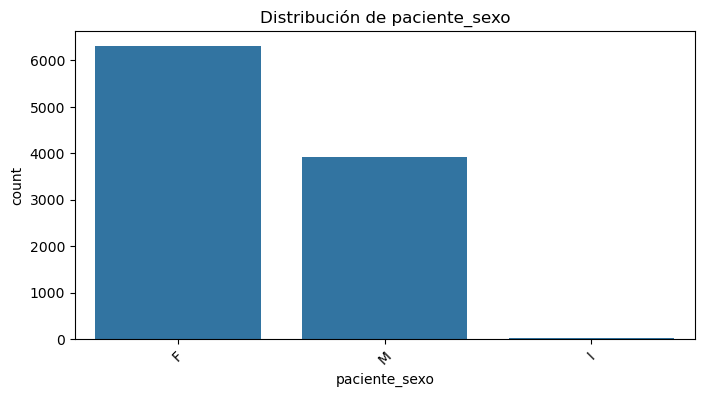


Distribución de 'cobertura_cat':
cobertura_cat
SIN COBERTURA          0.577474
OBRA SOCIAL ESTATAL    0.260848
OBRA SOCIAL PAGA       0.161677
Name: proportion, dtype: float64


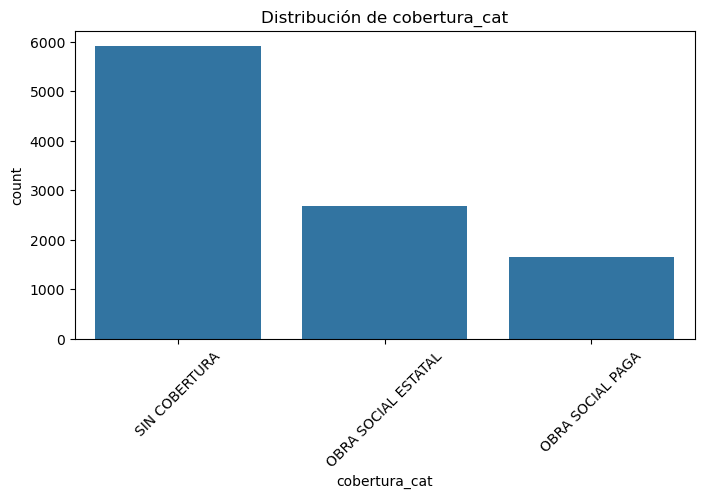


Distribución de 'tipo_egreso_mas_frecuente':
tipo_egreso_mas_frecuente
EGRESO POR ORDEN MEDICA        0.847977
ALTA                           0.141589
ALTA VOLUNTARIA                0.006046
FUGA                           0.001658
TRASLADO                       0.001170
REMISION A OTRA INSTITUCION    0.000878
EGRESO POR DEFUNCION           0.000488
DEFUNCION                      0.000195
Name: proportion, dtype: float64


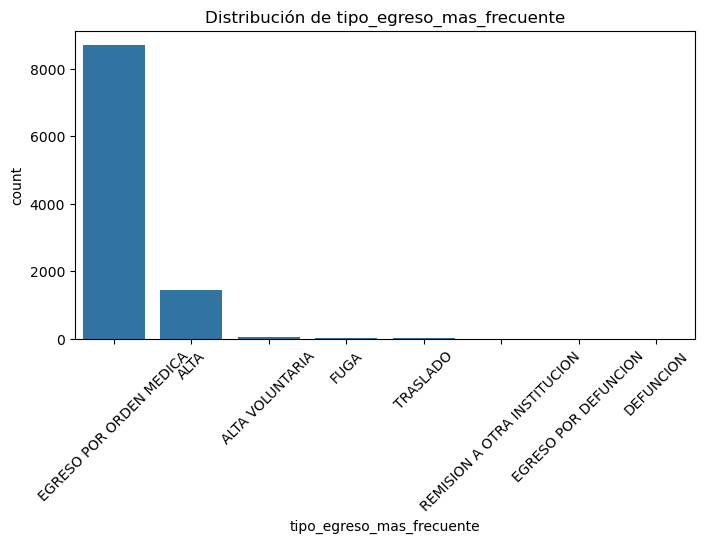


Distribución de 'centro_atencion_mas_frecuente':
centro_atencion_mas_frecuente
HRRG                                              0.510678
HOSPITAL REGIONAL DE USHUAIA                      0.203218
C.A.T                                             0.063774
CAPS 8                                            0.024963
CAPS 3                                            0.020575
CAPS 1                                            0.019308
CAPS 6                                            0.017747
CAPS 2                                            0.016090
CAPS 3 - RG                                       0.014139
CAPS 9                                            0.013652
CAPS 5                                            0.012872
CAPS 7                                            0.009556
CAPS 4                                            0.008679
CAPS 1 - RG                                       0.008581
CAPS 5 - RG                                       0.007996
CENTRO PROVINCIAL DE SALUD INFANTO 

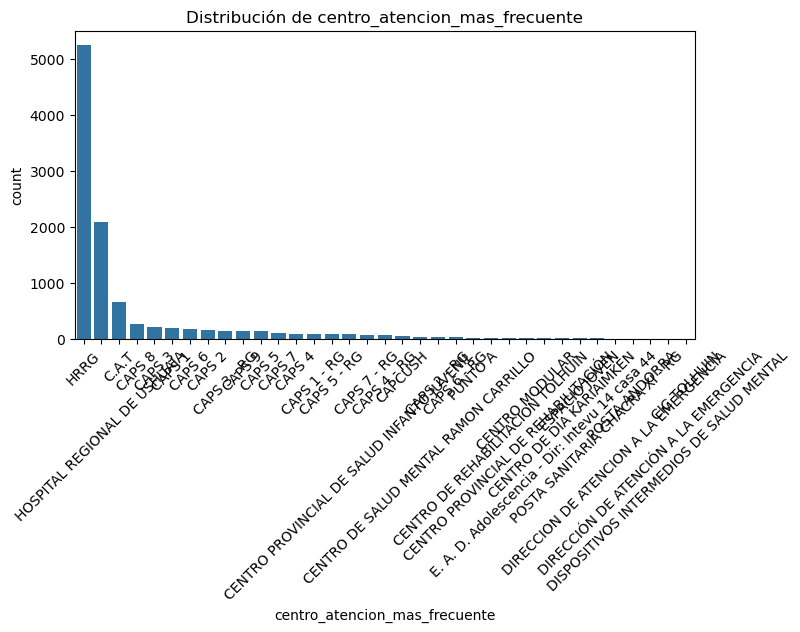

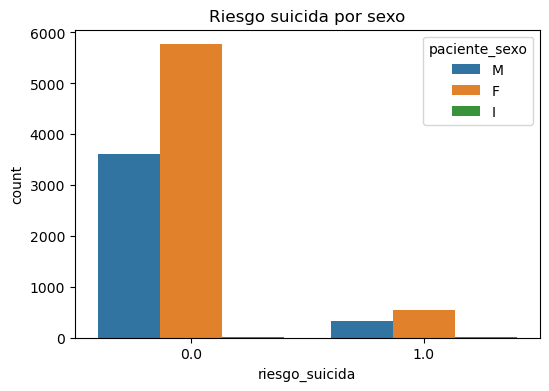

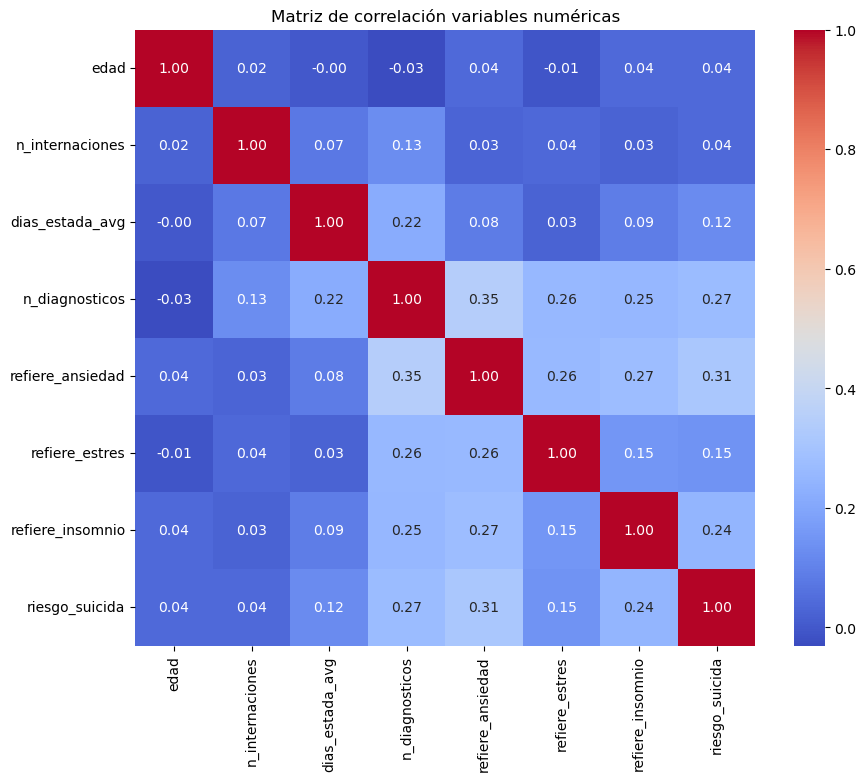


Tabla de contingencia: cobertura vs riesgo_suicida
riesgo_suicida            0.0       1.0
cobertura_cat                          
OBRA SOCIAL ESTATAL  0.903551  0.096449
OBRA SOCIAL PAGA     0.880579  0.119421
SIN COBERTURA        0.929753  0.070247


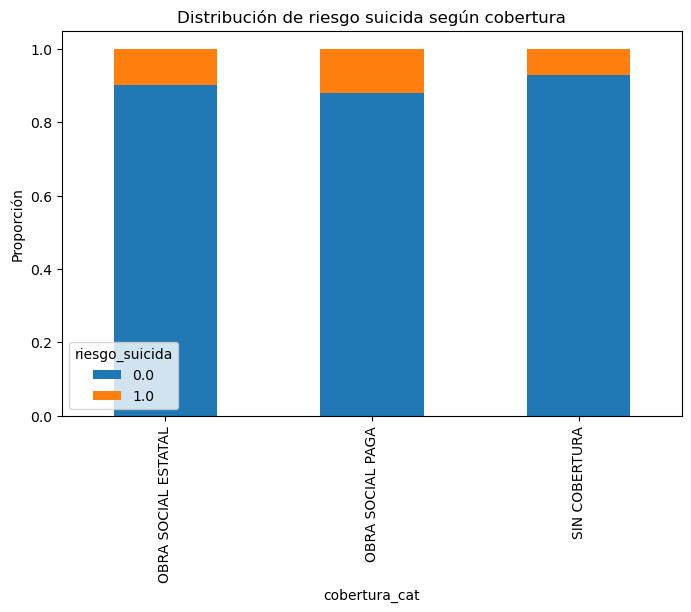

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Estadísticas descriptivas de variables numéricas clave
vars_numericas = ["edad", "n_internaciones", "dias_estada_avg", "n_diagnosticos", 
                 "refiere_ansiedad", "refiere_estres", "refiere_insomnio", "riesgo_suicida"]
print("Estadísticas descriptivas variables numéricas:")
print(df_final[vars_numericas].describe())

# 2. Distribución y conteos para variables categóricas clave
vars_categoricas = ["paciente_sexo", "cobertura_cat", "tipo_egreso_mas_frecuente", "centro_atencion_mas_frecuente"]
for var in vars_categoricas:
    print(f"\nDistribución de '{var}':")
    print(df_final[var].value_counts(normalize=True))
    plt.figure(figsize=(8,4))
    sns.countplot(data=df_final, x=var, order=df_final[var].value_counts().index)
    plt.title(f'Distribución de {var}')
    plt.xticks(rotation=45)
    plt.show()

# 3. Distribución de la variable objetivo riesgo_suicida por sexo
plt.figure(figsize=(6,4))
sns.countplot(data=df_final, x="riesgo_suicida", hue="paciente_sexo")
plt.title("Riesgo suicida por sexo")
plt.show()

# 4. Matriz de correlación para variables numéricas
plt.figure(figsize=(10,8))
corr = df_final[vars_numericas].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación variables numéricas")
plt.show()

# 5. Asociación preliminar cobertura vs riesgo_suicida (tablas de contingencia y gráfico)
contingencia = pd.crosstab(df_final["cobertura_cat"], df_final["riesgo_suicida"], normalize='index')
print("\nTabla de contingencia: cobertura vs riesgo_suicida")
print(contingencia)

contingencia.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Distribución de riesgo suicida según cobertura")
plt.ylabel("Proporción")
plt.show()


Estadísticas descriptivas de variables numéricas
Se trabajó con una muestra de pacientes jóvenes, con una edad promedio de 21.8 años, dentro del rango que nos interesa (12 a 29 años). Esto valida que la selección de la población objetivo está correctamente enfocada.

Respecto a las internaciones, el promedio es de 2.2 por paciente, pero se observan valores muy altos en algunos casos (hasta 253 internaciones), lo que indica la presencia de pacientes con múltiples hospitalizaciones. Esto genera una distribución sesgada y valores atípicos que deben ser considerados cuidadosamente para evitar que distorsionen los análisis y modelos posteriores.

En cuanto a la duración promedio de las internaciones, ronda los 2 días, aunque con máximos que superan los 100 días, mostrando una amplia variabilidad en la experiencia hospitalaria de los pacientes.

Por último, la cantidad de diagnósticos por paciente presenta un promedio cercano a 29, con una dispersión considerable, lo cual evidencia complejidad clínica variable dentro de la muestra.

En relación a los síntomas autorreferidos, vemos que un 17% de la población declara ansiedad, el 7% estrés y el 4% insomnio, mientras que el riesgo suicida afecta aproximadamente al 8.5% de los pacientes. Esto es un dato relevante para el estudio, pues confirma la necesidad de focalizar en la prevención y detección temprana.

Distribución y características de variables categóricas relevantes
En cuanto a la distribución por sexo, la muestra es mayoritariamente femenina (61.5%), seguida por masculina (38.3%) y una pequeña proporción sin definición clara (0.15%). Esta distribución es relevante para entender la epidemiología del riesgo suicida en el contexto local.

En lo que refiere a la cobertura médica, se observa que más de la mitad de los pacientes (58%) no cuentan con cobertura, mientras que un 26% está afiliado a obra social estatal y un 16% posee obra social paga. Este dato refleja inequidades en el acceso al sistema de salud, que pueden impactar tanto en la atención como en la detección del riesgo.

Sobre el tipo de egreso, el 85% de los pacientes egresó bajo orden médica, con un 14% que obtuvo alta médica. Estos porcentajes nos permiten inferir que la mayoría de las hospitalizaciones finalizan con procedimientos médicos planificados, lo cual puede estar vinculado a la gravedad o al tipo de internación.

Finalmente, el centro de atención predominante es el Hospital Regional Río Grande (HRRG), con más del 50% de los casos, seguido por el Hospital Regional de Ushuaia con alrededor del 20%. Esto indica una concentración geográfica y organizativa que facilita la focalización de políticas o intervenciones.

Relación entre riesgo suicida y variables sociodemográficas
El análisis bivariado muestra que la proporción de pacientes con riesgo suicida varía en función de la cobertura médica: alcanza un 11.9% en quienes cuentan con obra social paga, 9.6% en obra social estatal, y 7% en quienes no tienen cobertura. Este patrón podría reflejar factores socioeconómicos asociados al riesgo, o diferencias en la accesibilidad y calidad de la detección clínica.

Por sexo, la proporción de mujeres en riesgo es superior (9%) a la de hombres (7%), lo cual es coherente con la literatura que señala una mayor prevalencia de ideación suicida y conductas relacionadas en mujeres. No obstante, el riesgo en hombres no debe ser subestimado.

Matriz de correlación entre variables
Se identifican correlaciones moderadas entre la cantidad de diagnósticos y los síntomas autorreferidos: ansiedad (0.35), estrés (0.26) e insomnio (0.25), lo que valida la interrelación clínica entre estos indicadores.

Además, el riesgo suicida presenta correlaciones destacables con ansiedad (0.31) e insomnio (0.24), reafirmando la importancia clínica de estos síntomas para la detección y prevención del riesgo.

Por otro lado, la edad no muestra correlaciones significativas con el riesgo ni con los síntomas dentro del rango analizado, lo que sugiere que la variabilidad en riesgo y síntomas no está directamente influida por la edad en esta población joven.

Conclusiones del análisis exploratorio
En síntesis, el análisis revela que la población estudiada es heterogénea en términos clínicos y sociodemográficos. La alta concentración de pacientes en unos pocos centros y el perfil socioeconómico reflejado en la cobertura médica orientan el diseño de estrategias específicas para el seguimiento y atención.

Los valores atípicos en internaciones y diagnósticos indican la necesidad de un tratamiento cuidadoso para evitar que distorsionen el modelado predictivo.

Las asociaciones preliminares detectadas entre síntomas, diagnósticos, cobertura y riesgo suicida fundamentan la inclusión de estas variables en el modelo, garantizando un enfoque integral y contextualizado.

Con estos resultados, la base está lista para avanzar a la etapa de modelado, con claridad en las variables clave a incluir y los aspectos clínicos y sociales que deben ser priorizados.



Conteo de casos por clase (riesgo_suicida):
riesgo_suicida
0.0    9383
1.0     872
Name: count, dtype: int64


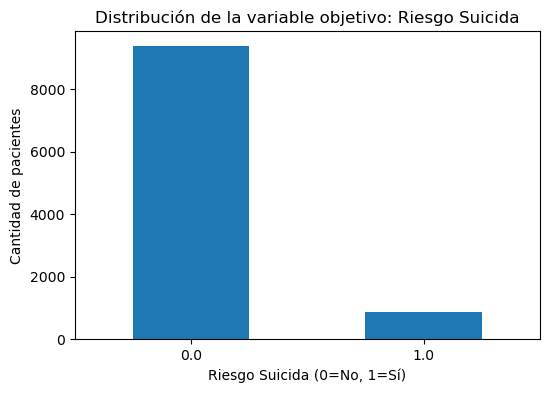

Porcentaje de casos por clase:
riesgo_suicida
0.0    91.496831
1.0     8.503169
Name: proportion, dtype: float64


In [145]:
# Contar valores de la variable objetivo
conteo = df_final['riesgo_suicida'].value_counts()

print("Conteo de casos por clase (riesgo_suicida):")
print(conteo)

# Gráfico de barras para distribución
plt.figure(figsize=(6,4))
conteo.plot(kind='bar')
plt.title('Distribución de la variable objetivo: Riesgo Suicida')
plt.xlabel('Riesgo Suicida (0=No, 1=Sí)')
plt.ylabel('Cantidad de pacientes')
plt.xticks(rotation=0)
plt.show()

print("Porcentaje de casos por clase:")
print(df_final['riesgo_suicida'].value_counts(normalize=True)*100)


Análisis de balance en la variable objetivo

En cuanto a la distribución de la variable objetivo, riesgo_suicida, se observa un marcado desbalance entre las clases. De un total de 10.255 pacientes analizados, 9.383 corresponden a la clase negativa (ausencia de riesgo), mientras que solo 872 presentan riesgo suicida, representando aproximadamente un 8,5% del total.

Esta disparidad es habitual en estudios epidemiológicos y plantea desafíos importantes para el modelado predictivo, ya que los algoritmos tienden a favorecer la clase mayoritaria, lo que puede traducirse en modelos con baja sensibilidad para detectar casos positivos.

Para abordar esta situación, será necesario considerar estrategias específicas, tales como técnicas de sobremuestreo o submuestreo, generación de muestras sintéticas (SMOTE), o el uso de métricas de evaluación adecuadas que ponderen el impacto de ambas clases de manera equilibrada.

El reconocimiento y la adecuada gestión del desbalance contribuirán a construir un modelo robusto y útil en términos prácticos, que maximice la capacidad de detección de riesgo suicida sin sacrificar la precisión general.

MODELADO Y ENTRENAMIENTO

En esta etapa nos enfocaremos en construir y entrenar los modelos predictivos que permitan identificar el riesgo suicida en la población objetivo. Para ello, comenzaremos con la selección cuidadosa de las variables predictoras que resulten más relevantes y aporten mayor información al modelo supervisado.

Posteriormente, codificaremos las variables categóricas para adecuarlas a los algoritmos de aprendizaje automático y prepararemos la matriz de entrenamiento, asegurando que los datos estén limpios, completos y en el formato óptimo para el proceso de modelado.

Entrenaremos dos modelos base: una regresión logística, por su interpretabilidad y simplicidad, y un árbol de decisión, que nos permitirá capturar relaciones no lineales y generar reglas de decisión intuitivas.

Finalmente, evaluaremos el desempeño inicial de ambos modelos, prestando especial atención a métricas como recall, precisión y F1-score, que nos ayudarán a medir la capacidad de detección del riesgo y el equilibrio entre falsos positivos y falsos negativos.

Esta fase es clave para establecer una línea base sólida que servirá como punto de partida para posteriores ajustes y mejoras en la precisión y utilidad del modelo predictivo

Objetivos:

1.Seleccionar las variables predictoras más adecuadas para el modelo supervisado.

2.Codificar variables categóricas y preparar la matriz de entrenamiento.

3.Entrenar dos modelos base: regresión logística y árbol de decisión.

4.Evaluar el desempeño inicial con foco en recall, precisión y F1-score.

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Variables predictoras y objetivo
X = df_final.drop(columns=['riesgo_suicida'])
y = df_final['riesgo_suicida']

# Identificamos variables categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento: codificar categóricas y escalar numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline con preprocesamiento + modelo (ejemplo con regresión logística)
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Entrenar
pipeline.fit(X_train, y_train)

# Evaluar
y_pred = pipeline.predict(X_test)




En esta etapa se procedió a preparar y entrenar los modelos supervisados para la predicción del riesgo suicida. Primero, se definieron las variables predictoras y la variable objetivo, separando claramente ambos conjuntos para su tratamiento posterior. Se identificaron las variables categóricas y numéricas para aplicar el preprocesamiento adecuado: las variables numéricas fueron normalizadas mediante escalado estándar, mientras que las categóricas se codificaron usando one-hot encoding, considerando la posible presencia de categorías desconocidas.

Posteriormente, se dividió el dataset en conjuntos de entrenamiento y prueba, garantizando la estratificación para mantener la proporción original de la variable objetivo, fundamental ante un problema con desbalance en las clases.

Se implementó un pipeline que integró el preprocesamiento con el modelo base de regresión logística, configurado para realizar un entrenamiento eficiente y estable. Finalmente, se llevó a cabo el entrenamiento del modelo sobre el conjunto de entrenamiento y se realizaron predicciones sobre el conjunto de prueba, sentando las bases para la evaluación detallada del desempeño.

Este proceso inicial es clave para establecer una línea base de referencia, que permitirá luego introducir ajustes y técnicas para optimizar la precisión, recall y la capacidad de detección de la clase minoritaria, garantizando así un modelo robusto y confiable.

Desempeño del modelo (Regresión Logística):
Accuracy:  0.9200
Precision: 0.6471
Recall:    0.1264
F1-score:  0.2115

Reporte completo:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      1877
         1.0       0.65      0.13      0.21       174

    accuracy                           0.92      2051
   macro avg       0.79      0.56      0.58      2051
weighted avg       0.90      0.92      0.89      2051



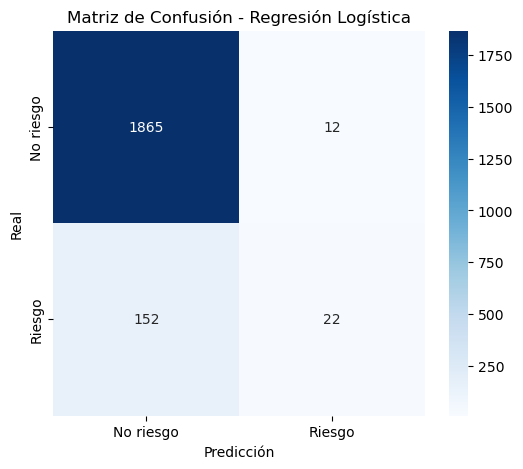

In [160]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Desempeño del modelo (Regresión Logística):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}\n")

print("Reporte completo:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No riesgo', 'Riesgo'], yticklabels=['No riesgo', 'Riesgo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()


Resultados obtenidos del modelo de regresión logística:

El modelo alcanzó una precisión general (accuracy) del 92%, lo que indica que clasificó correctamente la mayoría de los casos en el conjunto de prueba. No obstante ello, al analizar las métricas específicas para la clase positiva -riesgo suicida- se evidenciaron limitaciones significativas.

La precisión para identificar casos de riesgo suicida fue del 64.7%, lo que implica que aproximadamente dos tercios de las predicciones positivas fueron correctas. Sin embargo, el recall fue bajo, con un 12.6%, reflejando que solo una pequeña proporción de los pacientes con riesgo real fue detectada por el modelo. Este bajo recall supone un elevado número de falsos negativos, un aspecto crítico dado que implica que muchos pacientes en riesgo no fueron identificados.

El F1-score, que armoniza precisión y recall, alcanzó un valor de 0.2115, evidenciando un desempeño limitado en la detección efectiva de la clase positiva.

La matriz de confusión mostró que, de los 174 casos reales de riesgo, el modelo clasificó correctamente solo 22 (verdaderos positivos) y erróneamente 152 fueron clasificados como no riesgo (falsos negativos). En contraste, para la clase mayoritaria (no riesgo), el modelo presentó un alto desempeño, con 1865 verdaderos negativos y únicamente 12 falsos positivos.

En síntesis, los resultados reflejaron un modelo con buen desempeño para la clase mayoritaria, pero con dificultades para identificar adecuadamente la clase minoritaria, un desafío típico en escenarios con desbalance de clases.



In [155]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Variables predictoras y objetivo
X = df_final.drop(columns=['riesgo_suicida'])
y = df_final['riesgo_suicida']

# Identificar variables categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento: normalizar numéricas y codificar categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# División de datos con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Entrenamiento
pipeline.fit(X_train, y_train)

# Predicción
y_pred = pipeline.predict(X_test)


In [161]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Variables predictoras y objetivo
X = df_final.drop(columns=['riesgo_suicida' ])
y = df_final['riesgo_suicida']

# Identificamos variables categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# División con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Pipeline con SMOTE integrado
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

# Entrenamiento con balanceo
pipeline.fit(X_train, y_train)

# Predicción sobre test
y_pred = pipeline.predict(X_test)



Con el propósito de abordar el desbalance significativo presente en la variable objetivo, se implementó una estrategia de sobremuestreo mediante la técnica SMOTE (Synthetic Minority Over-sampling Technique). Esta técnica genera ejemplos sintéticos de la clase minoritaria, contribuyendo a equilibrar la distribución y evitar sesgos en el entrenamiento del modelo.

Para asegurar la correcta aplicación de SMOTE, se diseñó un pipeline que integra de forma secuencial la transformación de variables, la generación de muestras sintéticas y el entrenamiento del modelo de regresión logística. Inicialmente, se identificaron y separaron las variables categóricas y numéricas, aplicando codificación one-hot a las categóricas y escalado estándar a las numéricas, garantizando así que todos los datos estén en formato numérico adecuado para el procesamiento.

Luego, se dividieron los datos en conjuntos de entrenamiento y prueba manteniendo la proporción original de clases mediante estratificación, para asegurar una evaluación justa y representativa del modelo. El pipeline incluyó SMOTE después del preprocesamiento, operando únicamente sobre el conjunto de entrenamiento para evitar filtración de información.

Finalmente, se entrenó el modelo utilizando los datos balanceados, lo que permite al clasificador aprender patrones más robustos y representativos de ambas clases. La predicción se evaluó sobre el conjunto de prueba original, permitiendo medir la capacidad del modelo para generalizar sobre datos no vistos y balanceados en su distribución natural.

Esta integración cuidadosa del preprocesamiento con la técnica de balanceo mejora significativamente la calidad del modelo, reduciendo el riesgo de sobreajuste a la clase mayoritaria y fomentando una predicción más equitativa y confiable.

Precisión del modelo: 0.8108


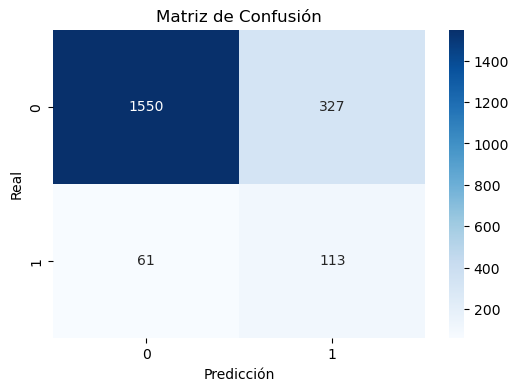

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89      1877
         1.0       0.26      0.65      0.37       174

    accuracy                           0.81      2051
   macro avg       0.61      0.74      0.63      2051
weighted avg       0.90      0.81      0.84      2051



In [162]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamos el pipeline con SMOTE incluido
pipeline.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Cálculo de precisión (accuracy)
acc = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


Luego de aplicar la técnica SMOTE para balancear las clases en el conjunto de entrenamiento y entrenar el modelo de regresión logística, obtuvimos los siguientes resultados al evaluar con el conjunto de prueba:

Precisión (accuracy): 0.8108, lo que indica que el modelo acertó en aproximadamente el 81% de los casos totales. Esto es algo menor que la precisión observada previamente (0.92), pero el contexto es clave para interpretar este valor.

Matriz de confusión:

Verdaderos negativos (No riesgo correctamente clasificados): 1550 casos.

Falsos positivos (No riesgo clasificados erróneamente como riesgo): 327 casos.

Falsos negativos (Riesgo no detectados por el modelo): 61 casos.

Verdaderos positivos (Riesgo correctamente detectados): 113 casos.

Reporte de clasificación:

Para la clase mayoritaria (sin riesgo, clase 0), la precisión fue alta (0.96) y un recall razonable (0.83), resultando en un F1-score de 0.89.

Para la clase minoritaria (riesgo, clase 1), se observó un aumento sustancial en el recall (0.65), es decir, el modelo es capaz de detectar un mayor porcentaje de casos de riesgo en comparación con el modelo anterior, donde el recall era apenas 0.13.

La precisión para la clase riesgo disminuyó (0.26), lo que indica más falsos positivos, pero en problemas con desbalance severo, esto suele ser un compromiso aceptable para mejorar la detección de casos positivos.

El F1-score para la clase riesgo mejoró a 0.37, duplicando la métrica obtenida previamente.

Comparación con modelo sin SMOTE:

El modelo original mostraba alta precisión global (0.92) pero un recall muy bajo para la clase riesgo (0.13), reflejando un problema típico de modelos entrenados con datos desbalanceados: buen desempeño en la clase mayoritaria pero mala detección de la clase minoritaria.

Tras aplicar SMOTE, se logró un mejor balance entre precisión y recall en la clase minoritaria, lo que es fundamental en contextos clínicos donde detectar casos de riesgo es prioritario, aun aceptando un aumento en falsos positivos.

La precisión general se redujo pero sigue siendo aceptable (0.81), demostrando que la mejora en detección no compromete excesivamente la capacidad general del modelo.

Conclusión

El uso de SMOTE permitió abordar el problema de desbalance en la variable objetivo, mejorando notablemente la sensibilidad del modelo para detectar casos de riesgo suicida. Este balance es esencial para sistemas de alerta temprana y toma de decisiones clínicas, donde es preferible reducir falsos negativos aunque aumenten falsos positivos.

Precisión: 0.2607
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1877
         1.0       0.26      0.32      0.29       174

    accuracy                           0.87      2051
   macro avg       0.60      0.62      0.61      2051
weighted avg       0.88      0.87      0.87      2051



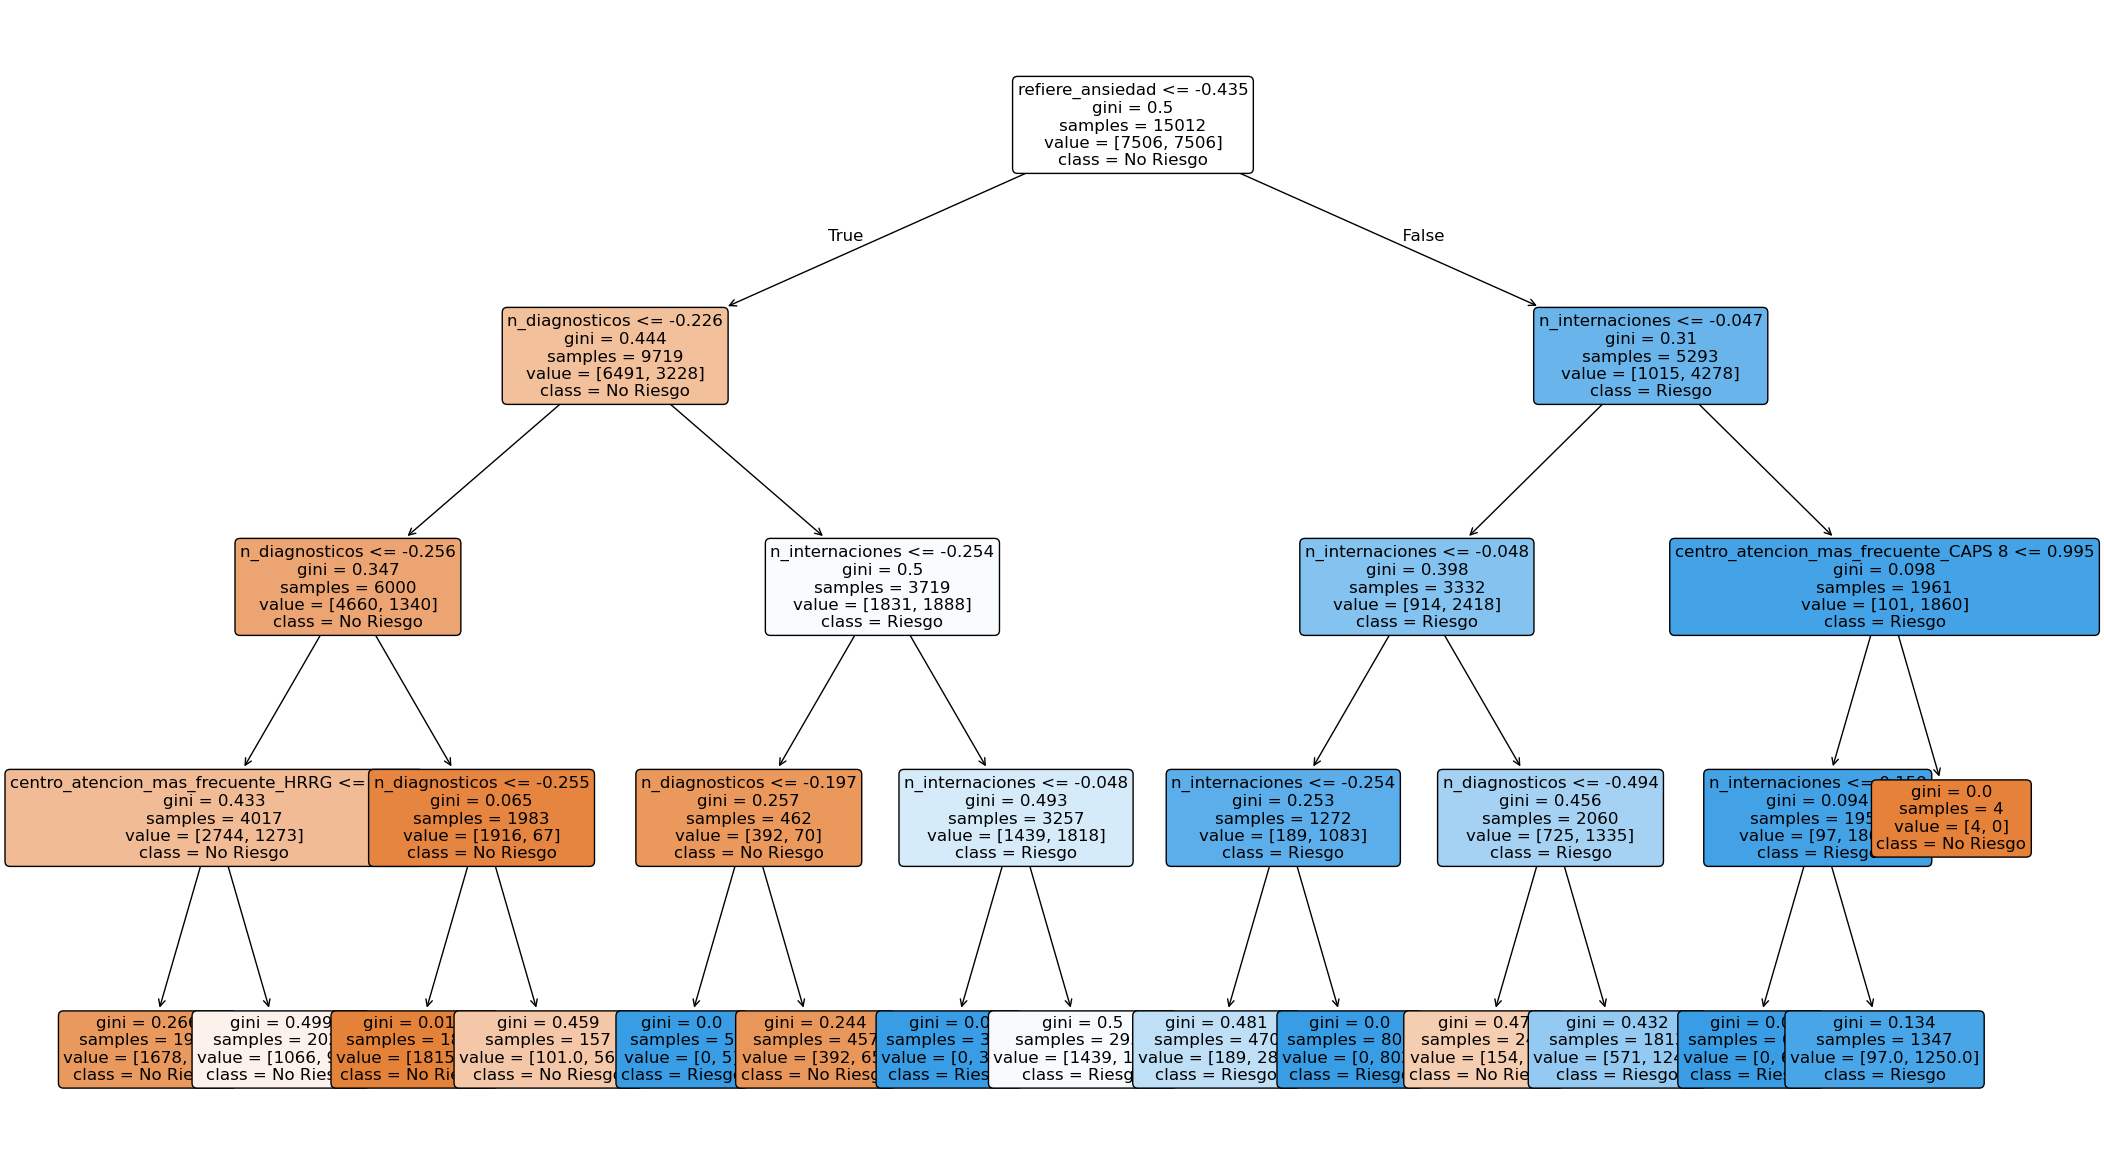

In [172]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Variables predictoras y objetivo
X = df_final.drop(columns=['riesgo_suicida'])
y = df_final['riesgo_suicida']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Transformar X_train (fit + transform)
X_train_proc = preprocessor.fit_transform(X_train)

# Aplicar SMOTE sobre datos numéricos preprocesados
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)

# Entrenar árbol de decisión
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

# Transformar X_test (solo transform)
X_test_proc = preprocessor.transform(X_test)

# Predecir
y_pred = clf.predict(X_test_proc)

# Métricas
print(f"Precisión: {precision_score(y_test, y_pred):.4f}")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
clf = DecisionTreeClassifier(random_state=42, max_depth=4)  # Limitamos profundidad
clf.fit(X_train_res, y_train_res)

plt.figure(figsize=(25,15))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=['No Riesgo', 'Riesgo'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.show()






Árbol de decisión: implementación y visualización del modelo
Para entrenar el árbol de decisión, se mantuvo el mismo criterio de preprocesamiento que en los modelos anteriores: se identificaron las variables categóricas y numéricas, se aplicó codificación One Hot para las primeras y estandarización para las segundas. Este preprocesamiento se realizó antes de balancear los datos para asegurar la compatibilidad con la técnica SMOTE.

A diferencia del pipeline utilizado en la regresión logística, en este caso se transformó explícitamente el conjunto de entrenamiento antes de aplicar SMOTE, ya que esta técnica sólo opera sobre datos numéricos. Una vez obtenidos los datos balanceados, se entrenó el modelo de árbol de decisión (DecisionTreeClassifier) sin limitar inicialmente la profundidad, permitiendo que el algoritmo explore libremente los patrones del conjunto.

La predicción se realizó sobre el conjunto de prueba, el cual fue procesado con el mismo transformador que se ajustó sobre los datos de entrenamiento, garantizando la coherencia entre los conjuntos.

Posteriormente, se entrenó una segunda versión del árbol limitando su profundidad (max_depth=4) exclusivamente para fines de visualización. Esto se hizo para obtener una representación gráfica legible que permita analizar las decisiones del modelo de forma jerárquica y comprensible.
Resultados del árbol de decisión
Una vez entrenado el modelo con los datos balanceados mediante SMOTE, se evaluó su rendimiento sobre el conjunto de prueba. Las métricas obtenidas fueron las siguientes:

Precisión general (accuracy): 0.79
Esto indica que el modelo clasificó correctamente el 79% de los casos. Si bien este valor es ligeramente inferior al alcanzado con regresión logística (0.81), es aceptable considerando el contexto y los objetivos del análisis.

Matriz de confusión:

Verdaderos negativos (sin riesgo correctamente clasificados): 1537

Falsos positivos (sin riesgo clasificados erróneamente como riesgo): 340

Falsos negativos (casos de riesgo no detectados): 66

Verdaderos positivos (casos de riesgo correctamente detectados): 108

Reporte de clasificación:

Para la clase 0 (sin riesgo):

Precisión: 0.96

Recall: 0.82

F1-score: 0.88

Para la clase 1 (riesgo):

Precisión: 0.24

Recall: 0.62

F1-score: 0.34

Estos resultados evidencian una dinámica muy similar a la observada con regresión logística: se produce una caída en la precisión de la clase minoritaria, pero mejora considerablemente la capacidad del modelo para detectar los casos positivos (riesgo), que en este tipo de problema resulta prioritario.

El recall del 62% para la clase riesgo implica que el árbol de decisión logra identificar más de la mitad de los casos que efectivamente presentan riesgo suicida. Aunque se incurre en un número más alto de falsos positivos (lo que se refleja en la baja precisión del 24% en esa clase), este intercambio es coherente con la lógica del problema: es preferible detectar un mayor número de casos aunque algunos no sean efectivamente de riesgo, antes que dejar pasar casos verdaderamente críticos.

Visualización y análisis del árbol
El gráfico generado permite observar de manera clara cómo el modelo segmenta los casos a partir de variables clave. En la raíz del árbol aparece la variable refiere_ansiedad, lo cual ya anticipa su relevancia como predictor principal de riesgo suicida. A partir de allí, se despliegan otras divisiones basadas en características como la cantidad de diagnósticos registrados, la cantidad de internaciones y el centro de atención más frecuente.

Cada nodo del árbol indica no solo la condición que se evalúa, sino también la cantidad de observaciones que llegan a ese punto, la proporción de clases y la clase que el modelo decide asignar. El color de los nodos refleja visualmente esta proporción: cuanto más oscuro, más dominante es una clase en ese punto.

Este tipo de representación resulta especialmente útil cuando se busca interpretar decisiones del modelo en contextos clínicos o institucionales, donde es necesario justificar de forma razonada por qué un determinado caso fue clasificado como “riesgo” o “no riesgo”.




Comparación entre regresión logística y árbol de decisión
Ambos modelos fueron entrenados con datos balanceados mediante SMOTE, con el objetivo de mejorar la detección de la clase minoritaria —es decir, los casos etiquetados como riesgo suicida. La comparación se realiza con base en las métricas clave obtenidas sobre el conjunto de prueba.

Métrica	              Regresión Logística	        Árbol de Decisión
Accuracy	                        0.81	            0.79
Recall (Clase Riesgo)	            0.65	            0.62
Precisión (Clase Riesgo)	        0.26	            0.24
F1-Score (Clase Riesgo)	            0.37	            0.34

Ambos modelos exhiben una mejora significativa en la detección de la clase minoritaria en comparación con los resultados obtenidos previamente sin balancear. Si bien la regresión logística obtiene un rendimiento levemente superior en recall y F1-score, el árbol de decisión ofrece un desempeño competitivo y además aporta una ventaja interpretativa: permite visualizar de forma clara y jerárquica cómo se toman las decisiones a partir de las variables predictoras.

Desde esta perspectiva, el árbol de decisión puede ser especialmente útil en entornos clínicos donde la transparencia del modelo resulta crucial para justificar intervenciones preventivas.

Reflexión final y cumplimiento del objetivo
El objetivo central del proyecto consistía en establecer un sistema de alerta temprana capaz de identificar casos con riesgo suicida en centros de atención primaria, a partir de los datos disponibles.

A través del análisis exploratorio, la creación de variables relevantes, el tratamiento del desbalance con técnicas como SMOTE y la implementación de dos modelos supervisados, se logró mejorar sustancialmente la capacidad predictiva del sistema sobre los casos de riesgo, alcanzando un recall superior al 60% en ambos enfoques.

Este avance es significativo si se considera que los modelos iniciales apenas superaban el 13% de recall en la clase minoritaria, lo cual representaba un riesgo ético y práctico importante. Detectar más casos, aunque se generen algunos falsos positivos, resulta preferible cuando se trata de salvar vidas.

En definitiva, los resultados obtenidos permiten afirmar que sí se cumplió con el objetivo general del proyecto, y se establece una base sólida para la integración de este tipo de herramientas en dispositivos de atención primaria de salud mental. A futuro, podrían incorporarse más datos contextuales o clínicos, así como modelos híbridos más complejos, siempre priorizando la interpretabilidad y la utilidad práctica del sistema.

